In [2]:
from sentence_transformers import SentenceTransformer

In [ ]:
#connect to an existing index

from pinecone import Pinecone

pc = Pinecone(api_key="pcsk_3StWu1_F4vFjfS4BMLmpvfuBE6aUyYE1LRVGetymK5Q4FHRBCFNbJWK2KRjtn1insArDth") #"New API key as of 4/18/2025"

test_index = pc.Index(name="test-index", host="https://test-index-mzzv42s.svc.aped-4627-b74a.pinecone.io")  

In [4]:
import pandas as pd

df = pd.read_csv("v2_cleaned_song_lyrics.csv")

In [ ]:
records = (
    df[['_id', 'Lyrics', 'Genre', 'Year', 'Track Name', 'Artist Name']]
      .rename(columns={
         'Lyrics': 'chunk_text',      #what gets embedded
         'Genre' : 'genre',        #metadata
         'Year'  : 'year',            # ^
         'Track Name' : 'track_name',      # ^
         'Artist Name': 'artist_name'      # ^
      })
    .to_dict(orient='records')
)

records

[{'_id': 'rec0',
  'chunk_text': "Let's take our time tonight, girl Above us all the stars are watchin' There's no place I'd rather be in this world Your eyes are where I'm lost in Underneath the chandelier We're dancin' all alone There's no reason to hide What we're feelin' inside Right now So, baby, let's just turn down the lights And close the door Oooh I love that dress But you won't need it anymore No, you won't need it no more Let's just kiss 'til we're naked, baby Versace on the floor Oooh take it off for me, for me, for me, for me now, girl Versace on the floor Oooh take it off for me, for me, for me, for me now, girl Now I unzip the back to watch it fall While I kiss your neck and shoulders No, don't be afraid to show it all I'll be right here ready to hold you Girl, you know you're perfect from Your head down to your heels Don't be confused by my smile 'Cause I ain't ever been more for real, for real So just turn down the lights And close the door Oooh I love that dress But y

example search

In [ ]:
#from pinecone's search example

# Search with a query text and rerank the results
# Supported only for indexes with integrated embedding
search_with_text = test_index.search(
    namespace="test-namespace", 
    query={
        "inputs": {"text": "spousal abuse"}, 
        "top_k": 4
    },
    fields=["category", "chunk_text"],
    rerank={
        "model": "bge-reranker-v2-m3",
        "top_n": 2,
        "rank_fields": ["chunk_text"] # Specified field must also be included in 'fields'
    }
)

print(search_with_text)

{'result': {'hits': [{'_id': 'rec4046',
                      '_score': 0.026506125926971436,
                      'fields': {'chunk_text': 'There was a girl I used to '
                                               'know She was oh so beautiful '
                                               "But she's not here anymore She "
                                               'had a college degree Smart as '
                                               'anyone could be Had so much to '
                                               'live for But she fell in love '
                                               'With the wrong kind of man He '
                                               'abused her love and treated '
                                               'her so bad There was not '
                                               'enough education in her world '
                                               'That could save the life of '
                                     

In [24]:
import random
some_ids = random.sample([r["_id"] for r in records], k=1000)

len(some_ids)

1000

In [ ]:

results = test_index.fetch(ids=some_ids, namespace="test-namespace")

#results

vectors_only = [(v.values) for v in results.vectors.values()]
vectors_and_metadata = [(v.values, v.metadata) for v in results.vectors.values()]

len(vectors_only)

959

PCA

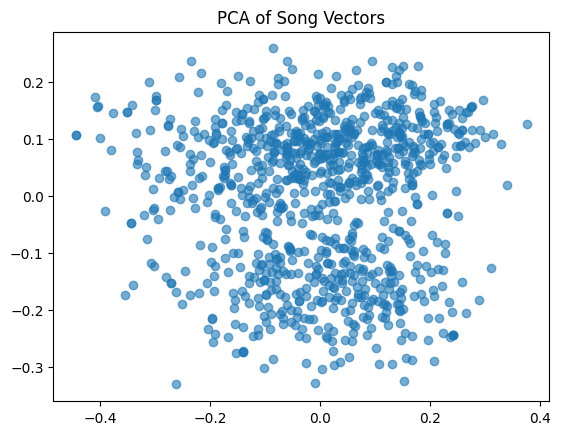

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors_only)

plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title("PCA of Song Vectors")
plt.show()


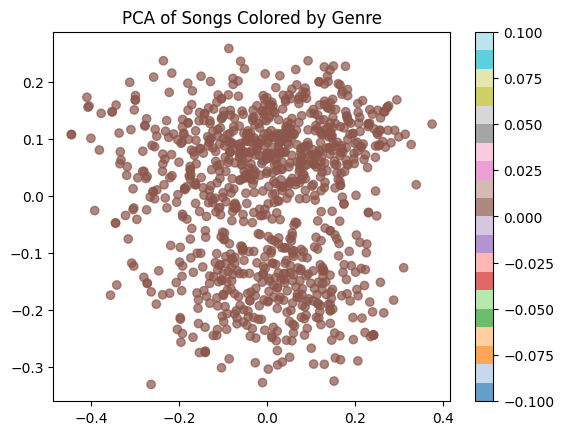

In [41]:
genres = [meta.get("Genre", "Unknown") for _, meta in vectors_and_metadata]
unique_genres = list(set(genres))
genre_to_color = {g: i for i, g in enumerate(unique_genres)}
colors = [genre_to_color[g] for g in genres]

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, cmap="tab20", alpha=0.7)
plt.title("PCA of Songs Colored by Genre")
plt.colorbar()
plt.show()


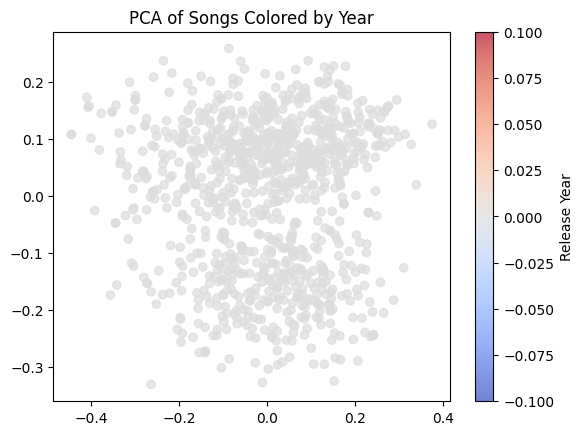

In [44]:
years = [int(str(meta.get("Year", "0"))[:4]) for _, meta in vectors_and_metadata]

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=years, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Release Year")
plt.title("PCA of Songs Colored by Year")
plt.show()


KMeans

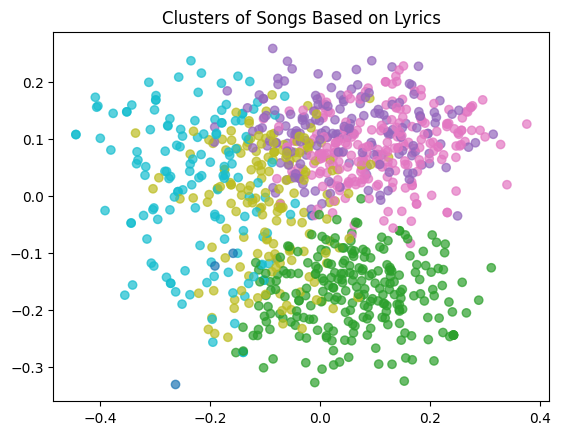

In [45]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0)
labels = kmeans.fit_predict(vectors_only)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("Clusters of Songs Based on Lyrics")
plt.show()

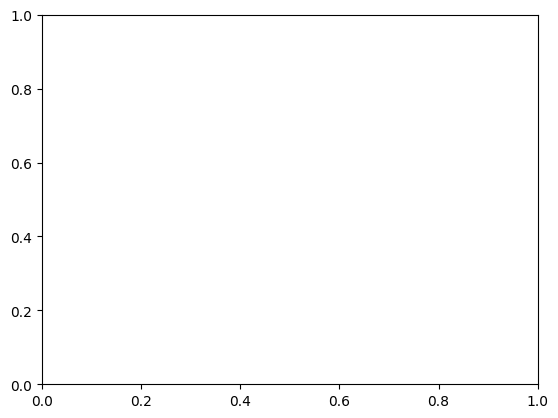

In [46]:
track_names = [meta.get("Track Name", "") for _, meta in vectors_and_metadata]

for i in range(0, len(pca_result), 30):
    plt.text(pca_result[i, 0], pca_result[i, 1], track_names[i], fontsize=7)


UMAP

In [47]:
!pip install umap-learn

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 16.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ----------- ---------------------------- 8.7/30.3 MB 41.3 MB/s eta 0:00:01
   ----------------------- ---------------- 17.6/30.3 MB 42.6 MB/s eta 0:00:01
   ------------------------------------ --- 27.5/30.3 MB 43.6 MB/s eta 0:00:01
   ---------------------------------------- 30.3/30.3 MB 37.0 MB/s eta 0:00:00


c:\Users\jnaid\demo_test\data_capstone_399\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


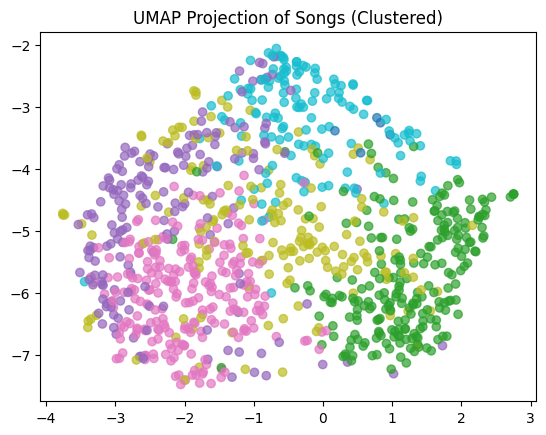

In [48]:
import umap.umap_ as umap

umap_result = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(vectors_only)

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("UMAP Projection of Songs (Clustered)")
plt.show()


In [57]:
for label in set(labels):
    print(f"\n--- Cluster {label} ---")
    for i in range(len(labels)):
        if labels[i] == label:
            print(f"{vectors_and_metadata[i][1]['Track Name']} by {vectors_and_metadata[i][1]['Artist Name']}")
            if i > 5: break



--- Cluster 0 ---


KeyError: 'Track Name'

In [55]:
%pip install plotly

In [56]:
import plotly.express as px

px.scatter(
    x=umap_result[:, 0],
    y=umap_result[:, 1],
    color=genres,
    hover_name=track_names,
    title="Lyrics Space Colored by Genre"
)


In [ ]:
import plotly.express as px
import pandas as pd

explorer_df = pd.DataFrame({
    "x": umap_result[:, 0],
    "y": umap_result[:, 1],
    "track": [m.get("Track Name", "") for _, m in vectors_and_metadata],
    "artist": [m.get("Artist Name", "") for _, m in vectors_and_metadata],
    "genre": [m.get("Genre", "Unknown") for _, m in vectors_and_metadata],
    "year": [str(m.get("Year", "Unknown"))[:4] for _, m in vectors_and_metadata]
})

fig = px.scatter(
    explorer_df,
    x="x", y="y",
    color="genre",
    hover_data=["track", "artist", "year"],
    title="Interactive Lyrics Explorer"
)
fig.show()


In [72]:
hiphop_vectors = [(v, m) for v, m in vectors_and_metadata if "rap" in m.get("Genre", "").lower()]
hiphop_vectors

[]

In [73]:

from collections import defaultdict
import numpy as np

#group hip hop songs by decade
decade_vectors = defaultdict(list)

for v, m in vectors_and_metadata:
    genre = m.get("Genre", "").lower()
    year = str(m.get("Year", ""))[:4]
    if "pop" in genre and year.isdigit():
        decade = year[:3] + "0s"
        decade_vectors[decade].append(v)

#compute average vector per decade,skip if sample size is under 5
avg_vectors = {
    decade: np.mean(vlist, axis=0)
    for decade, vlist in decade_vectors.items()
    if len(vlist) >= 5 and all(len(vec) == len(vlist[0]) for vec in vlist)
}

print("decades found:", avg_vectors.keys())



decades found: dict_keys([])


In [61]:
from sklearn.decomposition import PCA

decades = list(avg_vectors.keys())
pca_result = PCA(n_components=2).fit_transform(list(avg_vectors.values()))

plt.figure(figsize=(8,6))
for i, dec in enumerate(decades):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], label=dec)
    plt.text(pca_result[i, 0], pca_result[i, 1], dec, fontsize=9)
plt.legend()
plt.title("Lyrical Evolution of Hip Hop by Decade")
plt.show()


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.